**Задача**: 

Необходимо разработать механизм, позволяющий определить фейковые отзывы. Фейковый отзыв — проплаченный, нечестно мотивированный отзыв с целью повлиять на рейтинг товара.

Существует два вида таких отзывов:

- положительный отзыв написан для поставщика, который заказал себе этот отзыв; 
- отрицательный отзыв написан для другого поставщика с целью снизить рейтинг товара.

**Данные**

Cписок размеченных отзывов, со всей необходимой мета-информацией формате csv (пользователь, текст отзыва, оценка, является ли фейком)

**Результат**

Итогом работы должен стать набор скриптов, который позволяет по полученному на входе отзыву получить ответ, является отзыв фейковым, а также сформированная выдача для тестовых отзывов.

**Таргет** -  тагетом является - 'label'

**мл задача** - бинарный классификатор

**План проекта**

1.Понимание бизнес-проблемы

2.Изучение данных и ознакомление с ними(Изучение содержимого файлов, предварительная обработка для удобства дальнейшей работы.)

3.Подготовка данных к моделированию посредством обнаружения резко отклоняющихся значений, преобразования переменных, обработки пропущенных значений,Определение целевого признака.Кодирование признаков.Удаление ненужных признаков.Разбиение данных на выборки.
 Агрегрирование и объединение таблиц. Изучение целевого признака.

4.определить, что является для нас ключевой метрикой, к каким показателям качества стремиться;

5.подготовить несколько моделей машинного обучения (и анализ результата для внесения соответствующих изменений,выбираем лучшую модель на кросс-валидации)- разработать бинарный классификатор;  

6.Проверка модели с использованием нового набора данных(тестовый набор данных)

7.предоставить полноценный отчет с рекомендациями для бизнеса.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer 
from sklearn.ensemble import RandomForestClassifier



import re




import nltk
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
nltk.download('stopwords')
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 1234567

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
data =  pd.read_csv('/content/drive/MyDrive/wb/wb_school_task_2.csv')

In [3]:
data.head(88)


,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.000000,11,13,4.272727,18,36,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.700000,46,4,4.434783,90,109,1
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.000000,14,0,4.500000,4,6,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.000000,374,30,4.772727,14,15,1
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.000000,6,4,5.000000,26,33,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,11940918245053629620,4719958874970942221,2452047199270097551,"Заявлено: натуральная кожа, по факту эко-кожа....",1,1,1.000000,36,12,3.416667,18,23,0
84,15540418837550583163,391894388111194957,4563653250273761989,Вместо шампуня прислали гель для душа .,6,6,4.333333,9301,1177,4.360821,65,92,0
85,7224760967518899785,17814433773054004579,786100009375704691,Нужна была рубашка для мероприятия. Выбор пал ...,1,1,5.000000,49,11,4.448980,1,4,1
86,3882929632968334505,1886623432010494769,16573173798776858338,"В целом качество хорошее, но на рост 175см кор...",2,2,4.500000,2,0,3.500000,8,12,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123 entries, 0 to 3122
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id1     3123 non-null   uint64 
 1   id2     3123 non-null   uint64 
 2   id3     3123 non-null   uint64 
 3   text    3123 non-null   object 
 4   f1      3123 non-null   int64  
 5   f2      3123 non-null   int64  
 6   f3      3123 non-null   float64
 7   f4      3123 non-null   int64  
 8   f5      3123 non-null   int64  
 9   f6      3123 non-null   float64
 10  f7      3123 non-null   int64  
 11  f8      3123 non-null   int64  
 12  label   3123 non-null   int64  
dtypes: float64(2), int64(7), object(1), uint64(3)
memory usage: 317.3+ KB


*Комментарий:* Пропуски отсутствуют. Стоит проверить количество уникальных элементов для следующих признаков:'id1','id2','id3'. Для того чтобы понять, а какой id является id - пользователя 

In [5]:
data.describe()

,id1,id2,id3,f1,f2,f3,f4,f5,f6,f7,f8,label
count,3.123000e+03,3.123000e+03,3.123000e+03,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000,3123.000000
mean,9.129430e+18,9.227826e+18,9.372505e+18,19.409862,16.216459,4.232658,808.603586,216.628562,4.453445,48.155620,94.356708,0.264169
std,5.355614e+18,5.337195e+18,5.328720e+18,35.746560,26.070112,1.179999,2509.350075,802.154201,0.619495,67.107753,329.525613,0.440960
min,1.761133e+16,5.008190e+15,2.716666e+16,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
25%,4.528846e+18,4.499907e+18,4.713547e+18,2.000000,2.000000,4.076923,26.000000,6.000000,4.331071,8.000000,13.000000,0.000000
50%,9.018343e+18,9.283218e+18,9.120257e+18,8.000000,7.000000,4.764706,116.000000,26.000000,4.617978,30.000000,45.000000,0.000000
75%,1.378798e+19,1.376912e+19,1.395917e+19,23.000000,20.000000,5.000000,493.000000,110.000000,4.809556,65.000000,107.000000,1.000000
max,1.844348e+19,1.844196e+19,1.844430e+19,638.000000,550.000000,5.000000,35375.000000,15683.000000,5.000000,1058.000000,9243.000000,1.000000


In [6]:
data.shape

(3123, 13)

In [7]:
print("-NaN-")
data.isna().sum() 

-NaN-


id1      0
id2      0
id3      0
text     0
f1       0
f2       0
f3       0
f4       0
f5       0
f6       0
f7       0
f8       0
label    0
dtype: int64

In [8]:
duplicateRows = data[data.duplicated('id1')]

In [9]:
duplicateRows

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
46,3231785663555852656,15727904128262950318,3260081402716394163,"Замечательные, легкие,красивые! На свой 38, вз...",127,87,4.803150,10,3,5.000000,211,356,0
70,16665675694745683209,5553915940977950659,9276397251840000441,Пришли брюки другой фирмы,4,1,1.750000,2,0,1.000000,17,37,0
75,5002269436549863957,13669343433924914553,2452047199270097551,"Мне подошли размер в размер. Бежевые ,смотрятс...",40,2,5.000000,6,9,3.666667,13,43,1
79,5002269436549863957,11253309069675330304,2452047199270097551,Мне подошли размер в размер. Легко надела . Уд...,40,2,5.000000,8,9,4.250000,13,43,1
145,5002269436549863957,12540256564528009708,2452047199270097551,Хороши на холодную слякотную погоду. Смотрятся...,40,2,5.000000,4,5,4.250000,13,43,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2837,10060364292165283393,15458700454681076465,16104245430111915406,хорошая милочка *пилочка),24,24,4.500000,102,17,4.764706,33,40,0
2854,18126275315654839741,5331942982394469331,6751630855670206633,Идеальная упаковка! Молодцы! Будем ждать весн...,20,1,5.000000,7,0,5.000000,20,140,1
3014,15769832707736862359,1776242854810788807,2050700460988970797,Хороший комбезик,81,77,4.864198,6,0,5.000000,70,636,0
3020,709978154103824154,17449655681503133666,815378434367114826,"Всё хорошо, доставка в пункт выдачи заказов бу...",36,5,4.944444,8,7,4.125000,13,41,1


*Комментарий:* Id1 -больше похоже на id продовца.Так как  один id может повторятся, как у сумок,так и у обуви. Судя по комментарию 

In [10]:
duplicatetext = data[data.duplicated(['text'])]

In [11]:
duplicatetext 

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
46,3231785663555852656,15727904128262950318,3260081402716394163,"Замечательные, легкие,красивые! На свой 38, вз...",127,87,4.803150,10,3,5.000000,211,356,0
668,10346926462856798093,48713247734723378,5819862898931104355,Не оригинал,16,2,2.750000,4,0,4.000000,6,19,1
854,566853433692149476,15538630578571792865,5401932919188249170,Все отлично!,1,1,5.000000,4,0,5.000000,4,9,0
908,1067420748339676671,12751391871732575740,5973287941210242510,Отличный товар,32,31,4.968750,13,6,3.384615,60,78,0
920,3855994546007340378,5036526099335298831,8822637423341064045,Все отлично,5,5,4.800000,119,10,4.588235,8,10,0
931,2190073306598487136,10663392092561612328,16435932279958888502,Отличный товар,3,3,5.000000,4,4,5.000000,60,100,0
932,13400895139560065441,18029157270792019550,16944585785021488632,Все отлично,3,3,5.000000,1,0,5.000000,21,28,0
976,13940963354727118969,1708038596130570250,8223254633971568382,Отличный товар,23,22,4.826087,388,66,4.935567,36,40,0
991,65558817233465147,9764230189506184940,13603654093158122472,Отличный товар,7,3,5.000000,50,7,4.760000,38,56,0
1191,8776732628784065398,9321762976318024234,928100110523606381,Отличный товар,3,2,4.333333,12,1,4.666667,10,17,1


In [12]:
data[data.duplicated()]

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
46,3231785663555852656,15727904128262950318,3260081402716394163,"Замечательные, легкие,красивые! На свой 38, вз...",127,87,4.80315,10,3,5.0,211,356,0


In [13]:
data.duplicated().sum()

1

In [14]:
data=data.drop_duplicates()

In [15]:
data.duplicated().sum()

0

*Комментарий:* Дубликаты были выявлены, и удалины 

In [16]:
data

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,7596126584852021591,173777575861152844,18254136755182295358,"Хотела купить на замену старых,по итогу эти у...",1,1,1.000000,11,13,4.272727,18,36,0
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.700000,46,4,4.434783,90,109,1
2,2636757786779776109,16985421652518589249,4904562693381133981,"Кабель подошёл, хорошо работает.",4,4,4.000000,14,0,4.500000,4,6,0
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.000000,374,30,4.772727,14,15,1
4,11933982800034911890,14531191561111600318,9121890650636487522,Визуально все хорошо. Не пробовали. Купили в п...,19,18,5.000000,6,4,5.000000,26,33,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3118,764513678578182418,15635360211325277203,6836784353719029392,"Стекло не плохое,но есть один минус на техно с...",2,2,3.000000,19,1,4.263158,9,9,0
3119,6838893897482150395,13016265854619171030,12090430373311552618,"Всё пришло запаковано, ничего не сломано. Лучш...",8,8,4.375000,131,83,4.183206,18,18,0
3120,3080528623596565085,17787644417937804433,18003133089489520237,"Мне нравятся 👍🏻 я очень аллергичная, посоветов...",13,12,5.000000,145,2,4.944828,12,14,0
3121,13059704988549832630,997055248102065549,12214993272083833542,"Спасибо, целая пришла. Хорошо упаковано",3,3,5.000000,205,19,4.648780,103,155,0


In [17]:
data[['id1','id2','id3']].nunique()

id1    3049
id2    3006
id3     978
dtype: int64

In [18]:
df = data.copy()
del df['label'] 
del df['text'] 


In [19]:
df.corr()

,id1,id2,id3,f1,f2,f3,f4,f5,f6,f7,f8
id1,1.000000,-0.017750,-0.004652,-0.056074,-0.030798,-0.014593,0.031394,0.027379,-0.030509,-0.035534,-0.011011
id2,-0.017750,1.000000,-0.001681,0.031046,0.004818,0.020884,0.006080,0.019795,0.004043,-0.001046,-0.017513
id3,-0.004652,-0.001681,1.000000,-0.009237,0.016544,-0.023948,0.066787,0.070988,-0.029165,-0.004505,-0.023114
f1,-0.056074,0.031046,-0.009237,1.000000,0.827815,0.194426,-0.026414,-0.038764,0.140402,0.687309,0.273633
f2,-0.030798,0.004818,0.016544,0.827815,1.000000,0.218768,-0.008786,-0.028660,0.140267,0.563813,0.204734
f3,-0.014593,0.020884,-0.023948,0.194426,0.218768,1.000000,0.081251,0.063626,0.464714,0.157886,0.047307
f4,0.031394,0.006080,0.066787,-0.026414,-0.008786,0.081251,1.000000,0.844445,0.073684,-0.005223,-0.015572
f5,0.027379,0.019795,0.070988,-0.038764,-0.028660,0.063626,0.844445,1.000000,0.048823,-0.017244,-0.018999
f6,-0.030509,0.004043,-0.029165,0.140402,0.140267,0.464714,0.073684,0.048823,1.000000,0.127357,0.041017
f7,-0.035534,-0.001046,-0.004505,0.687309,0.563813,0.157886,-0.005223,-0.017244,0.127357,1.000000,0.575329


*Комментарий:* `Id1` - коррелирует с `f4`(0.03) и c `f5`(0.02)

`Id2` - коррелирует с `f1`(0.03) и c `f3`(0.02) 


`Id3` - коррелирует с `f4`(0.06) и c `f5`(0.07) 

In [20]:
good_reviews=data[data['label']==0]['f4']
bad_reviews=data[data['label']==1]['f4']


print("First 10 samples of good reviews\n".format(),good_reviews[:10])
print("First 10 samples of bad reviews\n".format(),bad_reviews[:10])

First 10 samples of good reviews
 0      11
2      14
4       6
5       8
6     173
8     210
9     337
12    132
14      6
15    116
Name: f4, dtype: int64
First 10 samples of bad reviews
 1       46
3      374
7       30
10     155
11     718
13      18
19     449
23      96
27    2397
32       3
Name: f4, dtype: int64


*Комментарий:* Судя по всему f4 является количество отзывов о товаре. И что можно заметить, фейковых больше 

In [21]:
dff= data.loc[(data['f1'] ==40)& 
                   (data.duplicated('id1'))]

                   
dff

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
75,5002269436549863957,13669343433924914553,2452047199270097551,"Мне подошли размер в размер. Бежевые ,смотрятс...",40,2,5.0,6,9,3.666667,13,43,1
79,5002269436549863957,11253309069675330304,2452047199270097551,Мне подошли размер в размер. Легко надела . Уд...,40,2,5.0,8,9,4.250000,13,43,1
145,5002269436549863957,12540256564528009708,2452047199270097551,Хороши на холодную слякотную погоду. Смотрятся...,40,2,5.0,4,5,4.250000,13,43,0
233,5002269436549863957,4707051732118680101,2452047199270097551,Вот такие классные ботиночки из натуральной за...,40,2,5.0,8,6,4.875000,13,43,1
327,5002269436549863957,17163190472521893796,7715615707067664181,Понравились- качество достойное! Мне подошли н...,40,2,5.0,8,6,4.500000,13,43,1
438,5002269436549863957,7184918404601862719,11037372112584364428,"Размер в размер плотно сели, но натуральная ко...",40,2,5.0,5,6,4.800000,13,43,0
542,5002269436549863957,2918697925375352353,2452047199270097551,"Меня привлекло ,то как сделана подошва, можно ...",40,2,5.0,19,17,4.368421,13,43,0
818,5002269436549863957,7793738754320529137,815378434367114826,Сумка сыну понравилась! Качество хорошее. Брак...,40,2,5.0,2,2,5.000000,13,43,1
1062,5002269436549863957,8779533373574352561,2452047199270097551,"Хорошие ботинки,удобные,смотрятся брутально. Н...",40,2,5.0,16,14,4.875000,13,43,1
1572,5002269436549863957,10564289729077721264,11037372112584364428,Мне подошли идеально. Я в восторге от дизайна ...,40,2,5.0,9,8,4.666667,13,43,1


*Комментарий:* ПО таблице можно заметить, что пользователь с айди "	5002269436549863957" имеет одинаковые `f1` и `f2`.Можно предположить, что `f1`- это количество отзывов, `f8`- это количество заказов.


In [22]:
df_1= data.loc[(data['f4'] > data['f5'])& 
                   (data.duplicated('id2'))]

                   
df_1

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
73,1992190224313627136,16027884528707561911,16573173798776858338,"Все отлично,по размеру подошло,советую)",1,1,5.000000,8979,3247,4.790423,3,7,1
368,1482015430901663140,16443907507530121007,16351792195234876872,Наушники топ! Все отлично работает! Мне нравится,1,1,5.000000,10192,5663,4.551413,7,17,1
413,13917070513124260850,17312677487485542503,4418384912070712745,"Мне корректор понравился, он удобный, нравится...",2,2,5.000000,1493,992,4.470194,0,2,1
564,15717954416807843481,2303877497702172368,9610637946385316086,"Маломерит, резина слабая.",2,2,4.000000,5395,744,4.587210,7,11,0
596,6814839622479989702,13826026673912676377,15053676552810216566,"Пришло целым, сыну подходит, краснота спала,сп...",1,1,5.000000,23,11,4.260870,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3049,18176665630855614061,9974303597109420242,16351792195234876872,Очень отличные наушники. Работают просто клас ...,2,2,3.500000,2284,1433,4.571366,23,27,0
3054,17693830864608768698,10629340613180462560,17158970054014620221,"покупаю не первый раз, все супер",4,4,4.500000,19770,2297,4.463075,99,102,1
3083,2737744621355532876,9788684407401633342,3507617455605171251,Офигенно рекомендую класс,23,19,4.826087,23718,7262,4.463530,43,47,1
3085,17564680862523094259,3345344880097563888,14918306419713499452,огонь!!!!!,7,7,4.857143,20419,4690,4.678780,24,24,0


*Комментарий:* При изучении таблицы и отзыва на сайте wb было выявлено, что `id2` - это айди товара , `id3`- это айди продавца.`f4`- количество отзывов о товаре, `f5`- количество фото товара,`f6` - средняя оценка товара по всем отзывам. `f3`- средняя оценка, которую ставит юзер

*Комментарий:* Теперь проверим баланс признаков - label

In [23]:
data['label'].value_counts()

0    2297
1     825
Name: label, dtype: int64

*Комментарий:*Построим диаграмму для лучшей визуализации

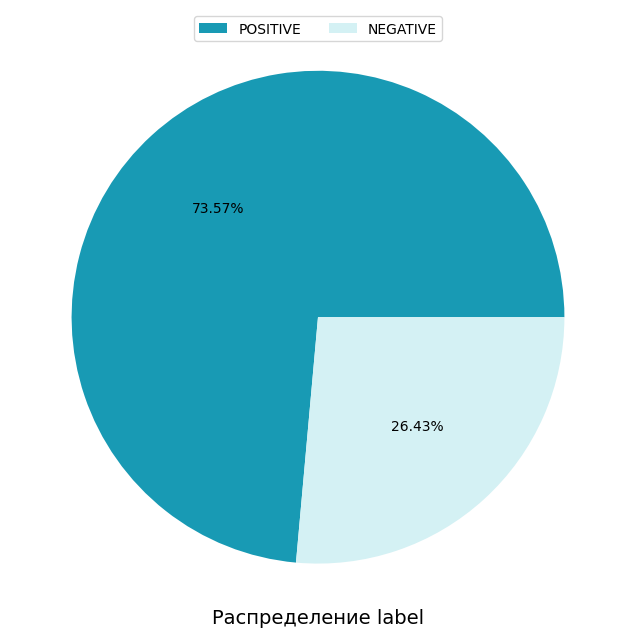

In [24]:

plt.figure(figsize = (8, 8))

labels = ['POSITIVE', 'NEGATIVE']
colors = ['#189AB4', '#D4F1F4']
plt.pie(data['label'].value_counts(), autopct='%0.2f%%',colors=colors)

plt.title('Распределение label', size=14, y=-0.01)
plt.legend(labels, ncol=2, loc=9)
plt.show()

<Axes: >

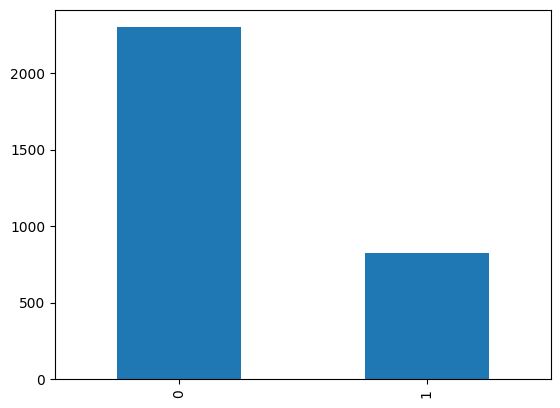

In [25]:
data['label'].value_counts().plot.bar()

*Комментарий:* Из графика видно, что присутствует сильный дисбаланс классов 

In [26]:

user_target =data.groupby('id1')['label'].mean()

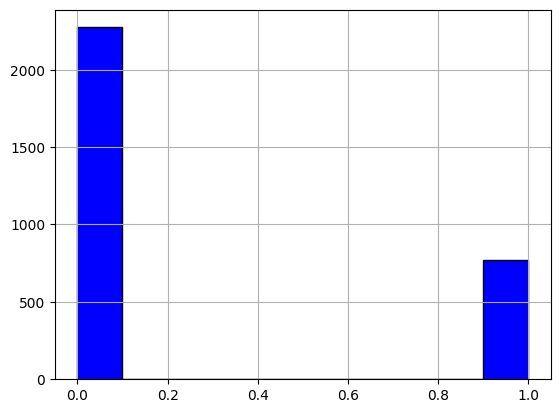

In [27]:
plt.hist(user_target, color = 'blue', edgecolor = 'black',
         bins = 10);
plt.grid(True)

In [28]:
fake_users = user_target.loc[user_target==1].index.to_list()

In [29]:
data.loc[data['id1'].sort_values().isin(fake_users)]

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
1,5327406586753254371,14366783259208998381,2324030737335224220,Запах по сравнению с обычным DOVE никакой. Оно...,10,6,2.700000,46,4,4.434783,90,109,1
3,15432976385014516263,2629180387521298831,13541353053200353836,"Восторг! Очень приятный аромат, держится долго...",6,6,5.000000,374,30,4.772727,14,15,1
7,8117888394773312960,374482498662209919,3608255627357219465,Хорошее качество,5,4,5.000000,30,1,4.600000,8,8,1
10,298483443235507048,9161312902389503914,18003133089489520237,"Хорошо упакован, Оригенал 👌🏻спасибо",12,12,5.000000,155,68,4.354839,15,19,1
11,13177061027481511402,6595073485018777246,15123516144979634006,Оыоырыгыоцрцныоцн,2,2,5.000000,718,178,4.554318,2,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,10046391362549256584,5450176251775713626,10827990466499151646,Очень вместительный. Брала за 580р. Все работа...,64,62,4.718750,69,23,4.666667,82,118,1
3095,3715826300767353883,14248822305452868164,8223254633971568382,"Классный чехол , сел как родной…",90,3,5.000000,5,0,5.000000,93,100,1
3101,5377145369530032933,13815619659284711422,6836784353719029392,довольна покупкой!👍🏻 советую,23,20,4.826087,238,40,4.638655,43,65,1
3106,16508910773142536176,4810020474718200925,6836784353719029392,"На айфон 13 стекло оказалось мало, как в ширин...",3,3,3.666667,305,103,4.672131,30,33,1


*Комментарий:* 

In [30]:
feats_corr = data[['f1','f2','f3','f4','f5','f6','f7','f8']].corr()

<Axes: >

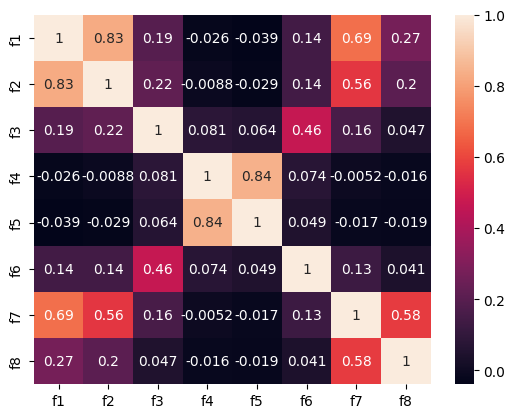

In [31]:
sns.heatmap(feats_corr, annot = True,fmt='.2g')

<Axes: ylabel='Density'>

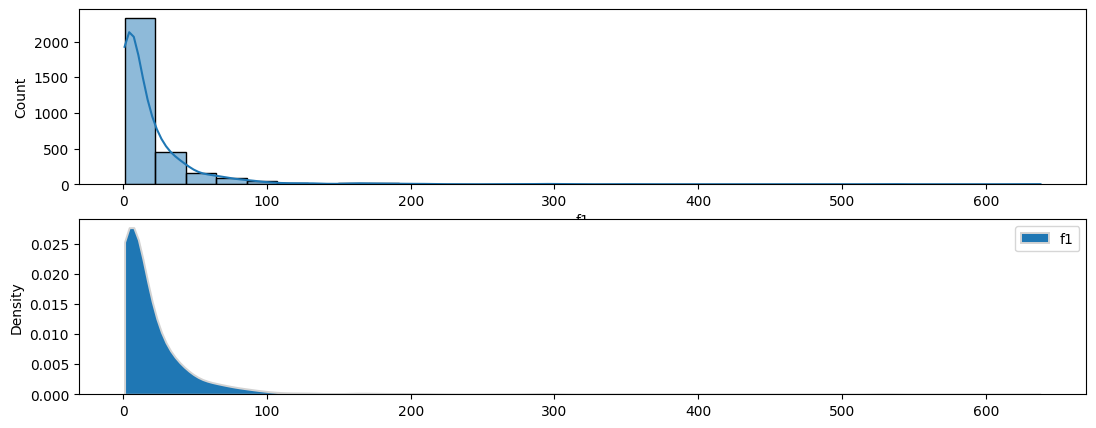

In [32]:
f_feature = data[['f1']]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 5))
sns.histplot(
    data=f_feature,
    x='f1',
    bins=30,
    kde=True,
    ax=axes[0]
);
sns.kdeplot(f_feature, 
                fill=True, ax=axes[1], cut=0, bw_method=0.25, 
                lw=1.4, edgecolor='lightgray', alpha=1) 

<Axes: ylabel='Density'>

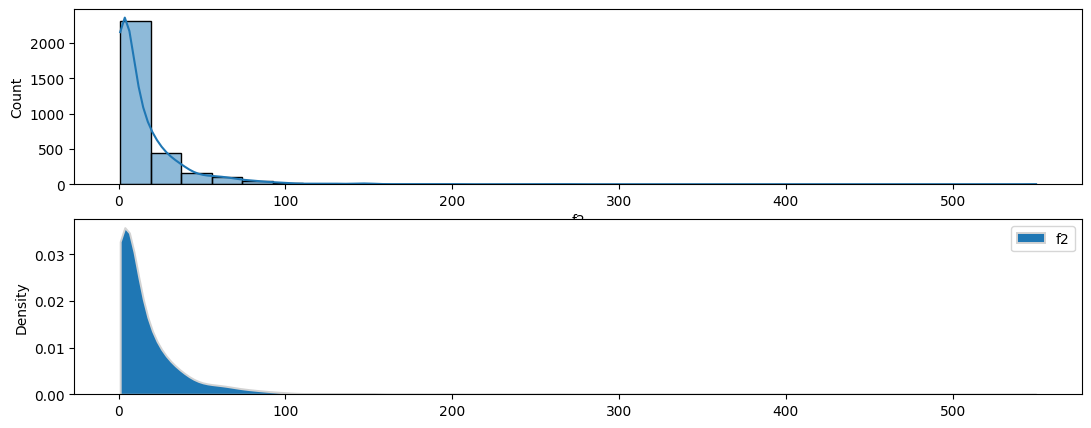

In [33]:

f_feature = data[['f2']]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 5))
sns.histplot(
    data=f_feature,
    x='f2',
    bins=30,
    kde=True,
    ax=axes[0]
);
sns.kdeplot(f_feature, 
                fill=True, ax=axes[1], cut=0, bw_method=0.25, 
                lw=1.4, edgecolor='lightgray', alpha=1) 

<Axes: ylabel='Density'>

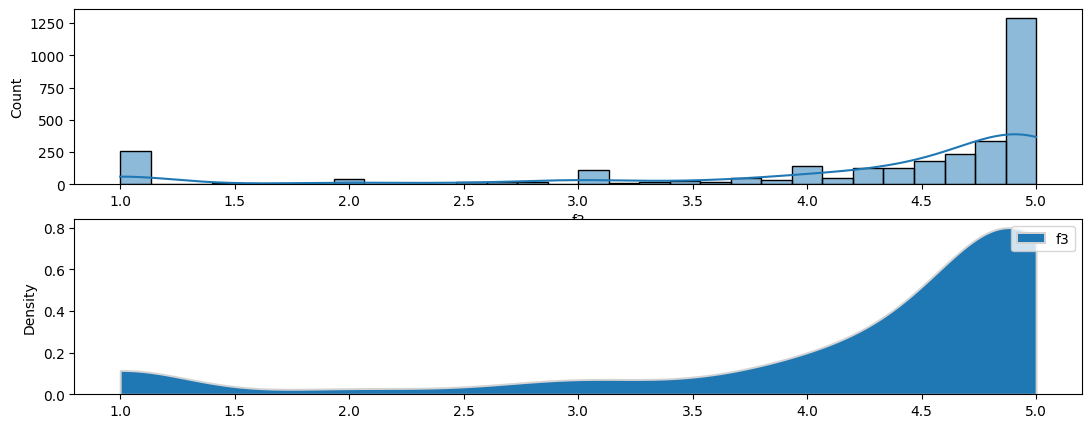

In [34]:

f_feature = data[['f3']]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 5))
sns.histplot(
    data=f_feature,
    x='f3',
    bins=30,
    kde=True,
    ax=axes[0]
);
sns.kdeplot(f_feature, 
                fill=True, ax=axes[1], cut=0, bw_method=0.25, 
                lw=1.4, edgecolor='lightgray', alpha=1) 

<Axes: ylabel='Density'>

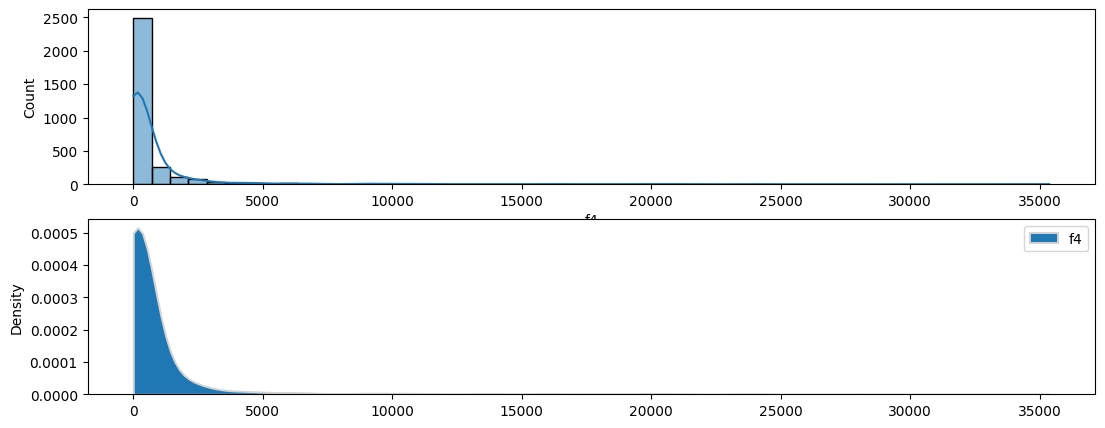

In [35]:

f_feature = data[['f4']]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 5))
sns.histplot(
    data=f_feature,
    x='f4',
    bins=50,
    kde=True,
    ax=axes[0]
);
sns.kdeplot(f_feature, 
                fill=True, ax=axes[1], cut=0, bw_method=0.25, 
                lw=1.4, edgecolor='lightgray', alpha=1) 

<Axes: ylabel='Density'>

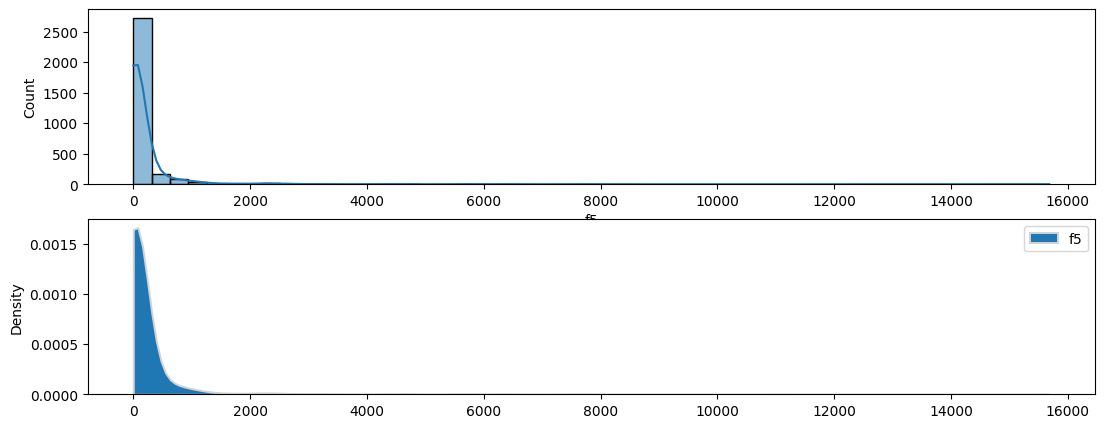

In [36]:

f_feature = data[['f5']]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 5))
sns.histplot(
    data=f_feature,
    x='f5',
    bins=50,
    kde=True,
    ax=axes[0]
);
sns.kdeplot(f_feature, 
                fill=True, ax=axes[1], cut=0, bw_method=0.25, 
                lw=1.4, edgecolor='lightgray', alpha=1) 

<Axes: ylabel='Density'>

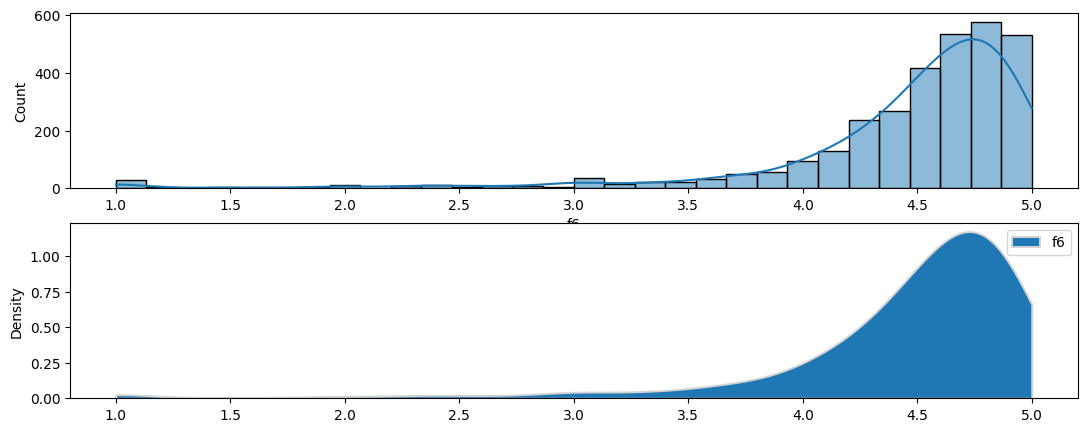

In [37]:

f_feature = data[['f6']]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 5))
sns.histplot(
    data=f_feature,
    x='f6',
    bins=30,
    kde=True,
    ax=axes[0]
);
sns.kdeplot(f_feature, 
                fill=True, ax=axes[1], cut=0, bw_method=0.25, 
                lw=1.4, edgecolor='lightgray', alpha=1) 

<Axes: ylabel='Density'>

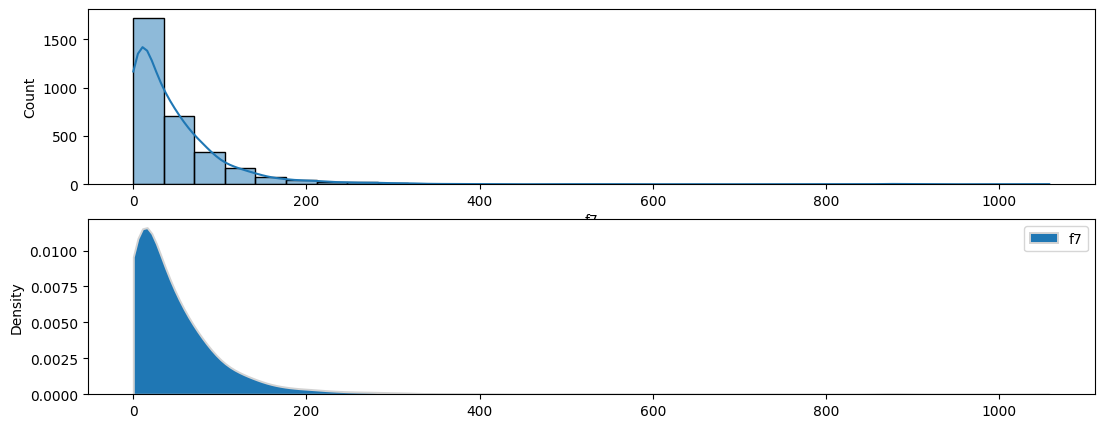

In [38]:

f_feature = data[['f7']]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 5))
sns.histplot(
    data=f_feature,
    x='f7',
    bins=30,
    kde=True,
    ax=axes[0]
);
sns.kdeplot(f_feature, 
                fill=True, ax=axes[1], cut=0, bw_method=0.25, 
                lw=1.4, edgecolor='lightgray', alpha=1) 

<Axes: ylabel='Density'>

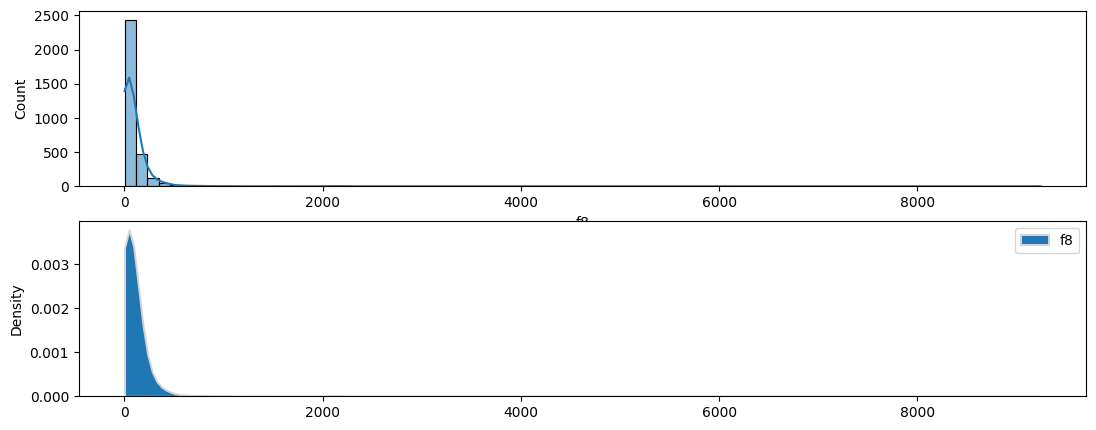

In [39]:

f_feature = data[['f8']]
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(13, 5))
sns.histplot(
    data=f_feature,
    x='f8',
    bins=80,
    kde=True,
    ax=axes[0]
);
sns.kdeplot(f_feature, 
                fill=True, ax=axes[1], cut=0, bw_method=0.25, 
                lw=1.4, edgecolor='lightgray', alpha=1) 

*Комментарий:* На основе EDA нельзя сделать вывод о том какие f-лучше всего оставить. Но на первый взгляд, кажется, что f6,f3 - является оценкой в чистом виде.  

(0.0, 2500.0)

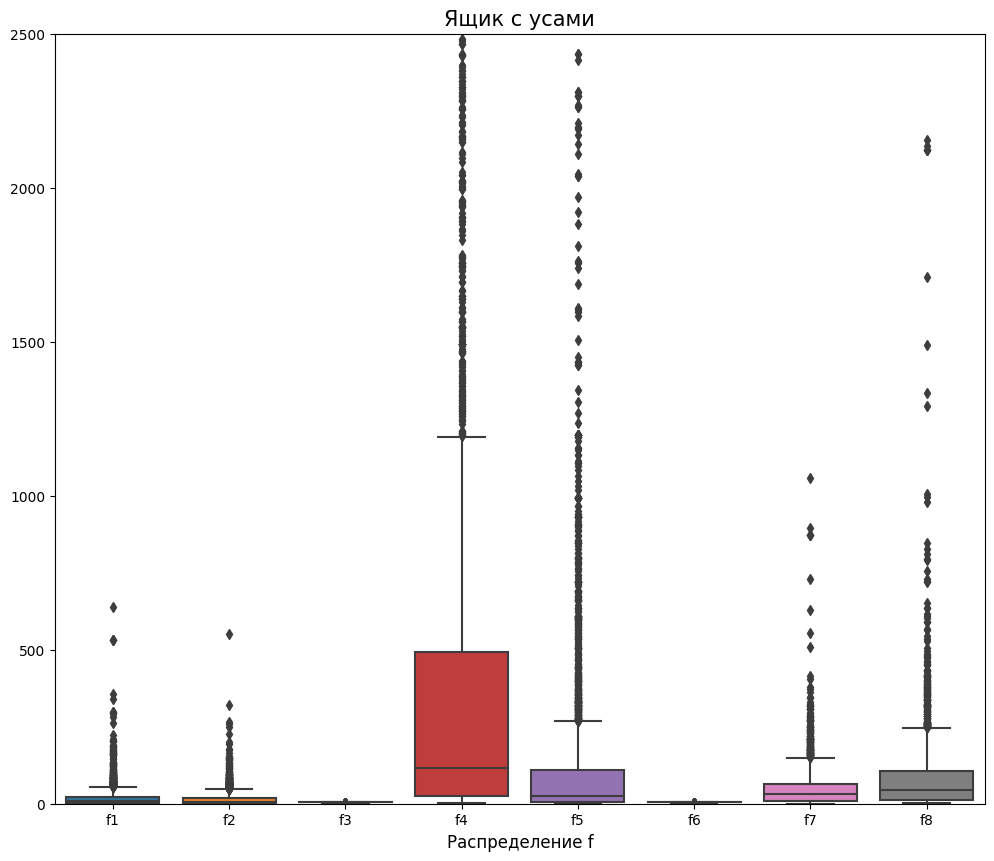

In [40]:
plt.figure(figsize=(12,10))
sns.boxplot(data=data[['f1','f2','f3','f4','f5','f6','f7','f8']])
plt.title('Ящик с усами', fontsize=15)
plt.xlabel('Распределение f', fontsize=12)

plt.ylim(0, 2500)


In [41]:
def cleaning(text):
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z+а-яА-ЯёЁ ]+", "", text).strip()
    
    text = text.lower()
    return text



data['text'] = data['text'].apply(cleaning)

In [42]:
data

,id1,id2,id3,text,f1,f2,f3,f4,f5,f6,f7,f8,label
0,7596126584852021591,173777575861152844,18254136755182295358,хотела купить на замену старыхпо итогу эти уж...,1,1,1.000000,11,13,4.272727,18,36,0
1,5327406586753254371,14366783259208998381,2324030737335224220,запах по сравнению с обычным dove никакой оно ...,10,6,2.700000,46,4,4.434783,90,109,1
2,2636757786779776109,16985421652518589249,4904562693381133981,кабель подошёл хорошо работает,4,4,4.000000,14,0,4.500000,4,6,0
3,15432976385014516263,2629180387521298831,13541353053200353836,восторг очень приятный аромат держится долго о...,6,6,5.000000,374,30,4.772727,14,15,1
4,11933982800034911890,14531191561111600318,9121890650636487522,визуально все хорошо не пробовали купили в под...,19,18,5.000000,6,4,5.000000,26,33,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3118,764513678578182418,15635360211325277203,6836784353719029392,стекло не плохоено есть один минус на техно сп...,2,2,3.000000,19,1,4.263158,9,9,0
3119,6838893897482150395,13016265854619171030,12090430373311552618,всё пришло запаковано ничего не сломано лучше ...,8,8,4.375000,131,83,4.183206,18,18,0
3120,3080528623596565085,17787644417937804433,18003133089489520237,мне нравятся я очень аллергичная посоветовал ...,13,12,5.000000,145,2,4.944828,12,14,0
3121,13059704988549832630,997055248102065549,12214993272083833542,спасибо целая пришла хорошо упаковано,3,3,5.000000,205,19,4.648780,103,155,0


In [43]:
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


In [44]:
def preprocess_text(text):
    text = str(text)
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and len(token)>=3 \
              and token.strip() not in punctuation \
              and token.isdigit()==False]
    text = " ".join(tokens)
    return text

In [45]:
data.text = data.text.apply(preprocess_text)

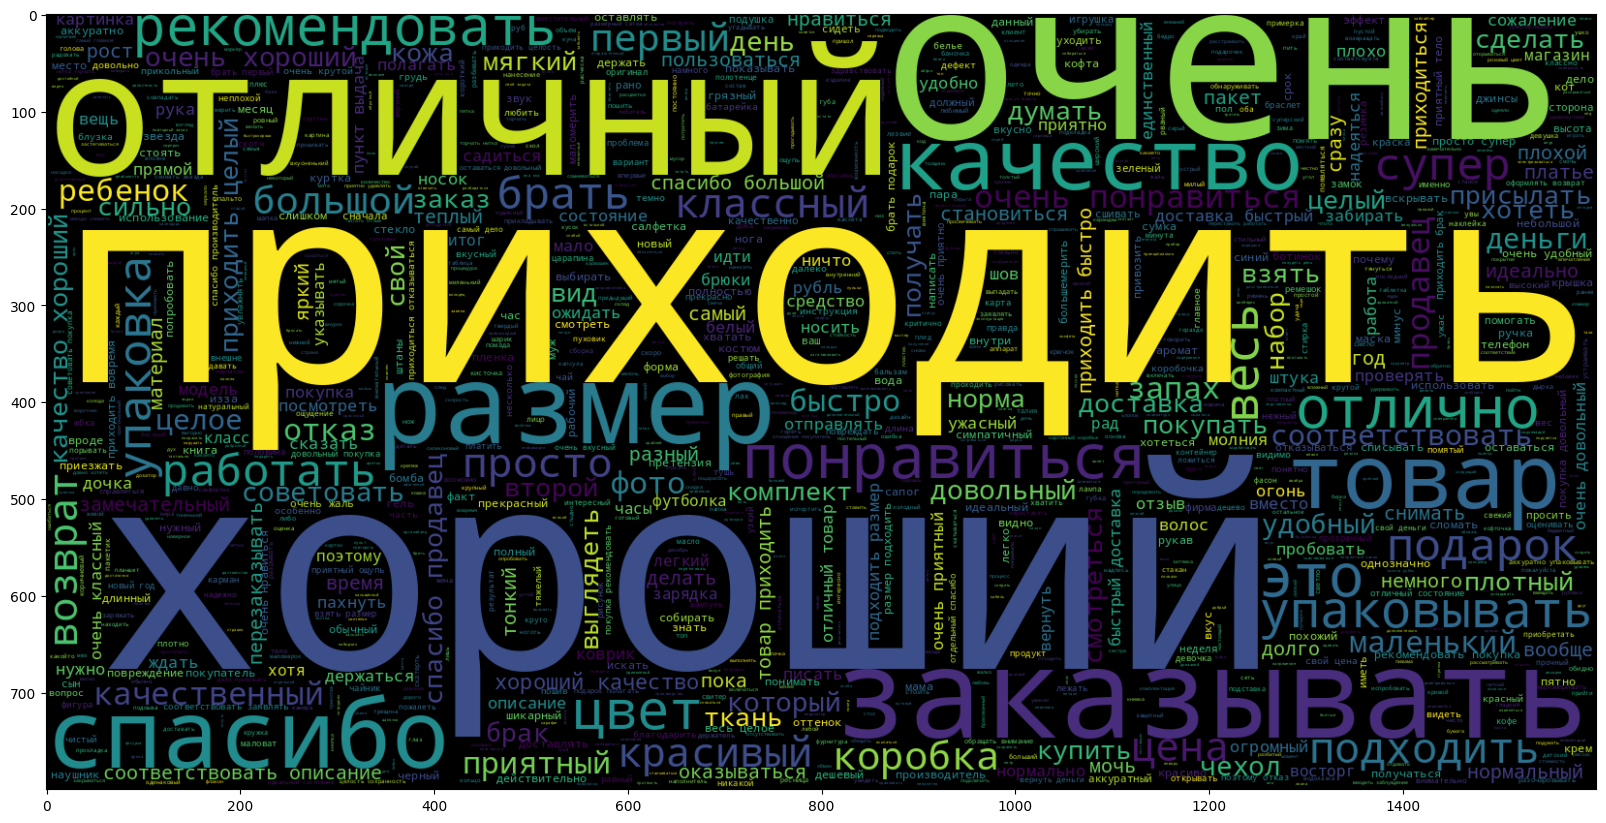

In [46]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(data[data.label == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

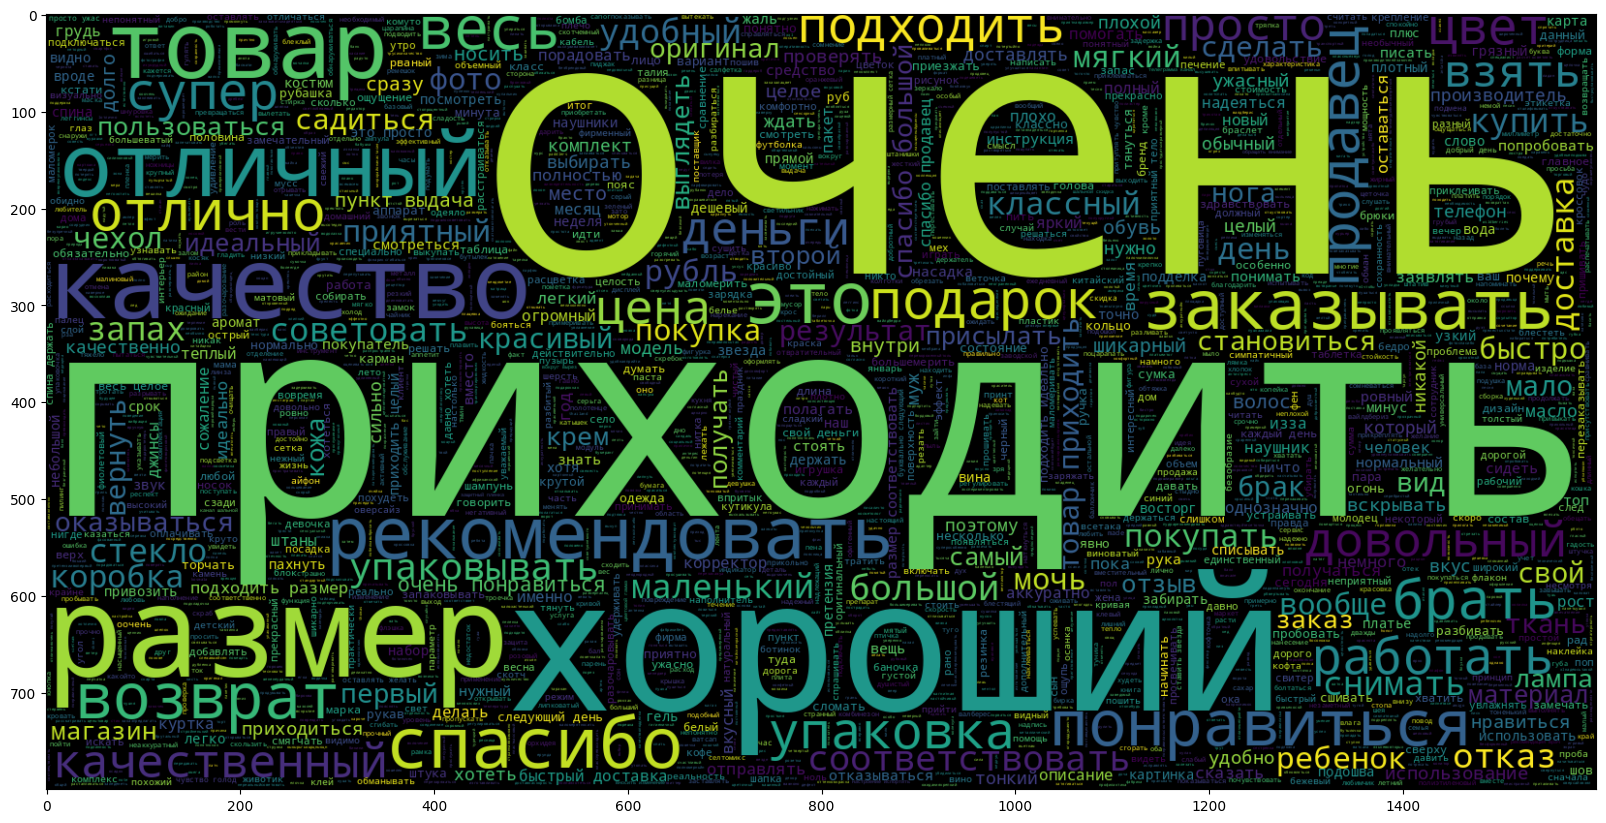

In [48]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(data[data.label == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

*Комментарий:* Разделю выборки целевой показатель label

In [113]:
features = data.text
target = data['label']

In [114]:
print(features.shape[0])
print(target.shape[0])

3122
3122


In [115]:
features_train,features_valid,target_train,target_valid =  train_test_split(features,target, test_size=0.4, random_state=RANDOM_STATE)
features_test, features_valid,target_test,target_valid =  train_test_split(features_valid,target_valid, test_size=0.5, random_state=RANDOM_STATE)

In [116]:

print('Размер обучающей выборки:', features_train.shape, target_train.shape)
print('Размер валидационной выборки:', features_valid.shape, target_valid.shape)
print('Размер тестовой выборки выборки:', features_test.shape, target_test.shape)


Размер обучающей выборки: (1873,) (1873,)
Размер валидационной выборки: (625,) (625,)
Размер тестовой выборки выборки: (624,) (624,)


In [117]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from imblearn.pipeline import Pipeline

In [118]:
text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))),
                     ('tfidf', TfidfTransformer()), 
                    ('clf', MultinomialNB())])

In [119]:
text_clf = text_clf.fit(features_train,target_train)

In [84]:
text_clf = text_clf.fit(features_valid,target_valid)

In [81]:
y_pred = text_clf.predict(features_test)

In [83]:
print('Score:', text_clf.score(features_test, target_test))

Score: 0.7211538461538461
